US_array
(2234,)
after
[1309567  847284  847284 ...  248151  248151 1837617]
[ 0.12723418 -0.12519088 -0.12519088 ... -0.28321096 -0.28321096
 -0.18222106]
[-0.90531814 -0.8907796  -0.8907796  ... -0.12609363 -0.12609363
 -0.25080577]
[0.40430745 0.43579215 0.43579215 ... 0.94772875 0.94772875 0.94772875]
[[ 0.12723418]
 [-0.12519088]
 [-0.12519088]
 ...
 [-0.28321096]
 [-0.28321096]
 [-0.18222106]] [[-0.90531814]
 [-0.8907796 ]
 [-0.8907796 ]
 ...
 [-0.12609363]
 [-0.12609363]
 [-0.25080577]] [[0.40430745]
 [0.43579215]
 [0.43579215]
 ...
 [0.94772875]
 [0.94772875]
 [0.94772875]]
0.0


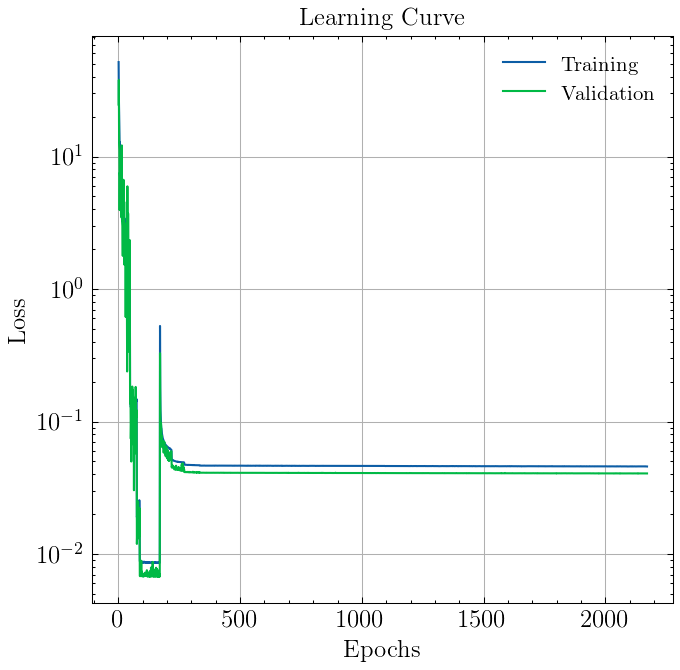

In [1]:
from model import *

# load model
model_path = "/home/taufikmh/KAUST/spring_2022/global_pinns/01_clean_implementations/models/2001_21_5e-06_166_91_181_<class 'torch.nn.modules.activation.ELU'>_False_2734186_512_sphere_gladm25_512_cartesian_<class 'torch.optim.adam.Adam'>_10_US_array_cuda"
figures_path = model_path + '/'
checkpoints_path = figures_path + 'checkpoints' + '/'
predictions_path = figures_path + 'predictions' + '/'

all_models = glob(model_path + '/Model_Epoch_*')

if all_models:
    latest_model = max(all_models, key=os.path.getctime)
else:
    print("It's empty")
    from train import *
    latest_model = max(glob(model_path + '/Model_Epoch_*'), key=os.path.getctime)

model = Model(model_path,VelocityClass=VelocityFunction(),device=torch.device('cpu'))
model.load(latest_model)


# load style
plt.style.use("./science.mplstyle")

# convergence history plot for verification
plt.figure()
ax = plt.axes()
ax.semilogy(np.arange(len(model.total_train_loss[160:]))+1,model.total_train_loss[160:],label='Training')
ax.semilogy(np.arange(len(model.total_train_loss[160:]))+1,model.total_val_loss[160:],label='Validation')
ax.set_xlabel('Epochs')
# plt.ylim(0.0001,0)
# plt.xticks(fontsize=10)
ax.legend()
# ax.xaxis.set_major_locator(plt.MultipleLocator(500))
plt.title('Learning Curve')
ax.set_ylabel('Loss')
# plt.yticks(fontsize=10);
plt.grid()
plt.savefig(figures_path + 'loss.png', bbox_inches="tight")

# depth to plot
depth_plot = 24
dep_plt = [
    depth_plot
]
dep_plt.append(dep_sou)

# mean prediction
V_pred_mean = 0
N = 0

(array([ 1606861.,    64498.,   140839.,   579228.,  3273713., 17483664.,
        15291436., 14115030., 16562826., 19898007.]),
 array([ 0.      ,  1.393542,  2.787084,  4.180626,  5.574168,  6.96771 ,
         8.361252,  9.754794, 11.148336, 12.541878, 13.93542 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

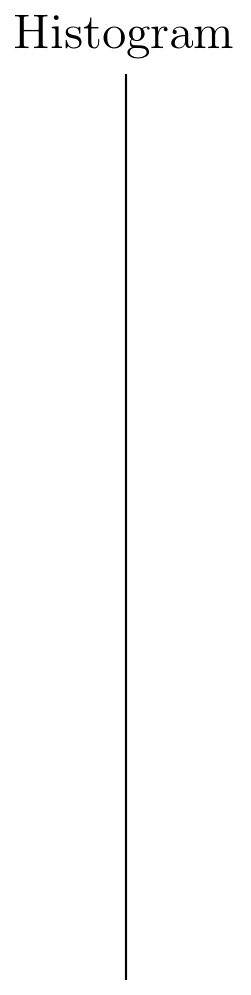

In [4]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = plt.axes(projection=ccrs.Robinson(180))

# print(pred.T_pred.values.min(), dep_sou)

ax.coastlines()
ax.gridlines()
data.vpv.plot(
    ax=ax, 
    transform=ccrs.PlateCarree()
)

In [5]:
Xb = np.zeros((1, lat_dim, lon_dim))

i = 0

lat_i, alt_i, lon_i = np.meshgrid(latitude, -1e3*depth_plot, longitude)
x_i, y_i, z_i = pm.geodetic2ecef(lat_i, lon_i, alt_i)
_, dep_i, _ = np.meshgrid(latitude, depth_plot, longitude)

# coordinates setup
sx, sy, sz = pm.geodetic2ecef(lat_sou[i], lon_sou[i], -1e3*dep_sou)

# rescale
x,y,z = x_i/(ear_rad*1e3), y_i/(ear_rad*1e3), z_i/(ear_rad*1e3)
sx, sy, sz = sx/(ear_rad*1e3), sy/(ear_rad*1e3), sz/(ear_rad*1e3)

X,Y,Z = x,y,z

print(X.size, lat_dim*dep_dim*lon_dim)

# define receiver coordinates
xR, yR, zR = X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)

# define source coordinates
xS, yS, zS = sx*np.ones_like(X.reshape(-1,1)), sy*np.ones_like(X.reshape(-1,1)), sz*np.ones_like(X.reshape(-1,1))

# define input to the neural network
Xo = np.hstack((xS, yS, zS, xR, yR, zR))


Xq = torch.utils.data.DataLoader(
    torch.from_numpy(Xo).to(torch.float).to(torch.device('cuda')),
    batch_size=int(Xo.shape[0]//10)
)

t0 = time.time()
T_pred = model.traveltimes(Xq, projection=False, normalization=True).cpu().reshape(-1, lat_dim, lon_dim)
print('Predicted in ' + str(time.time()-t0))
V_pred = model.velocity(Xq, projection=False, normalization=True).cpu().reshape(-1, lat_dim, lon_dim)

V_pred, T_pred = V_pred*bac_vel, T_pred/bac_vel

print(V_pred.shape)

16471 2734186
Predicted in 0.7478909492492676
torch.Size([1, 91, 181])


In [6]:
xS.shape

(16471, 1)

In [7]:
Xo.shape

(16471, 6)

16471 2734186
Predicted in 0.7818443775177002
torch.Size([1, 91, 181])


ValueError: Image size of 378727x1501 pixels is too large. It must be less than 2^16 in each direction.

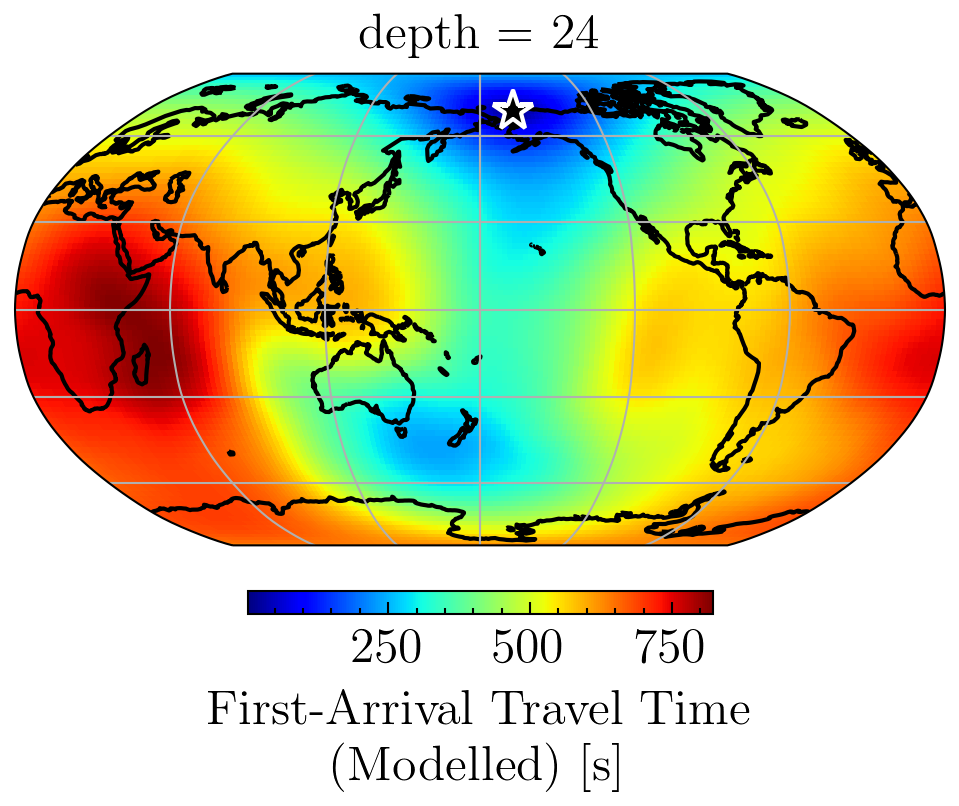

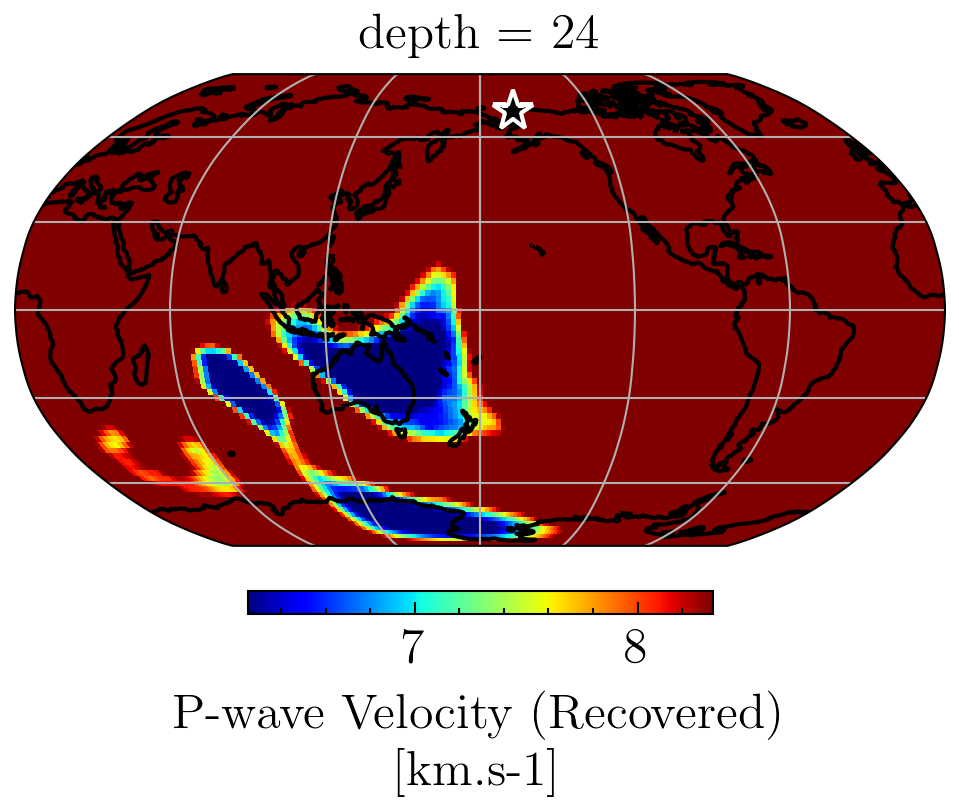

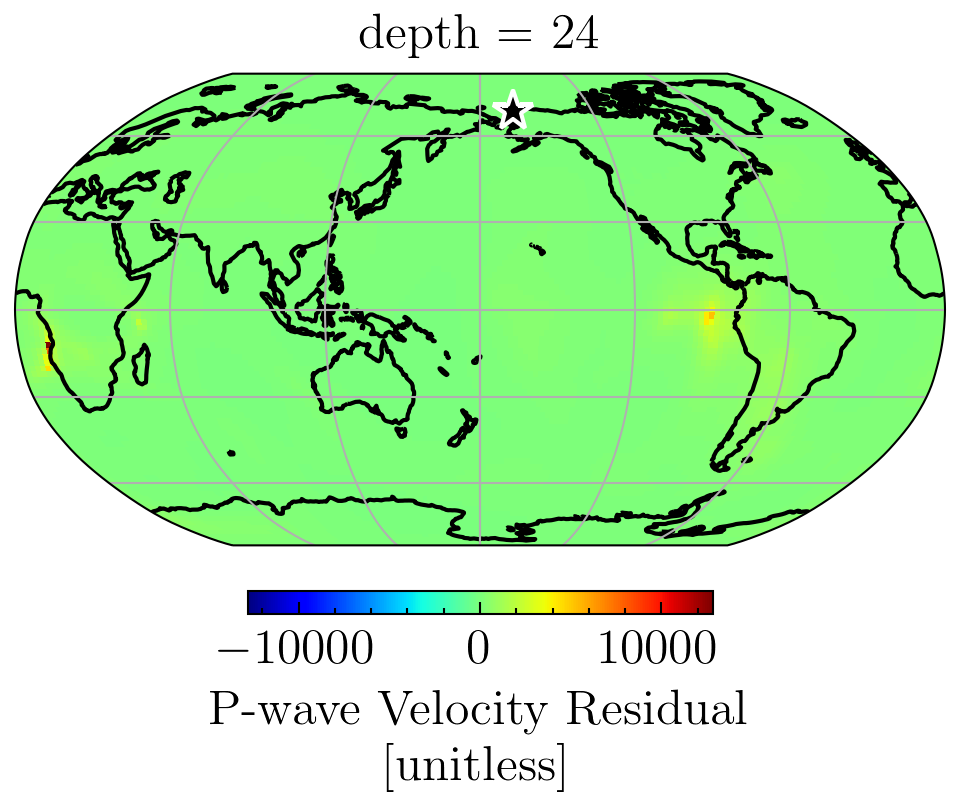

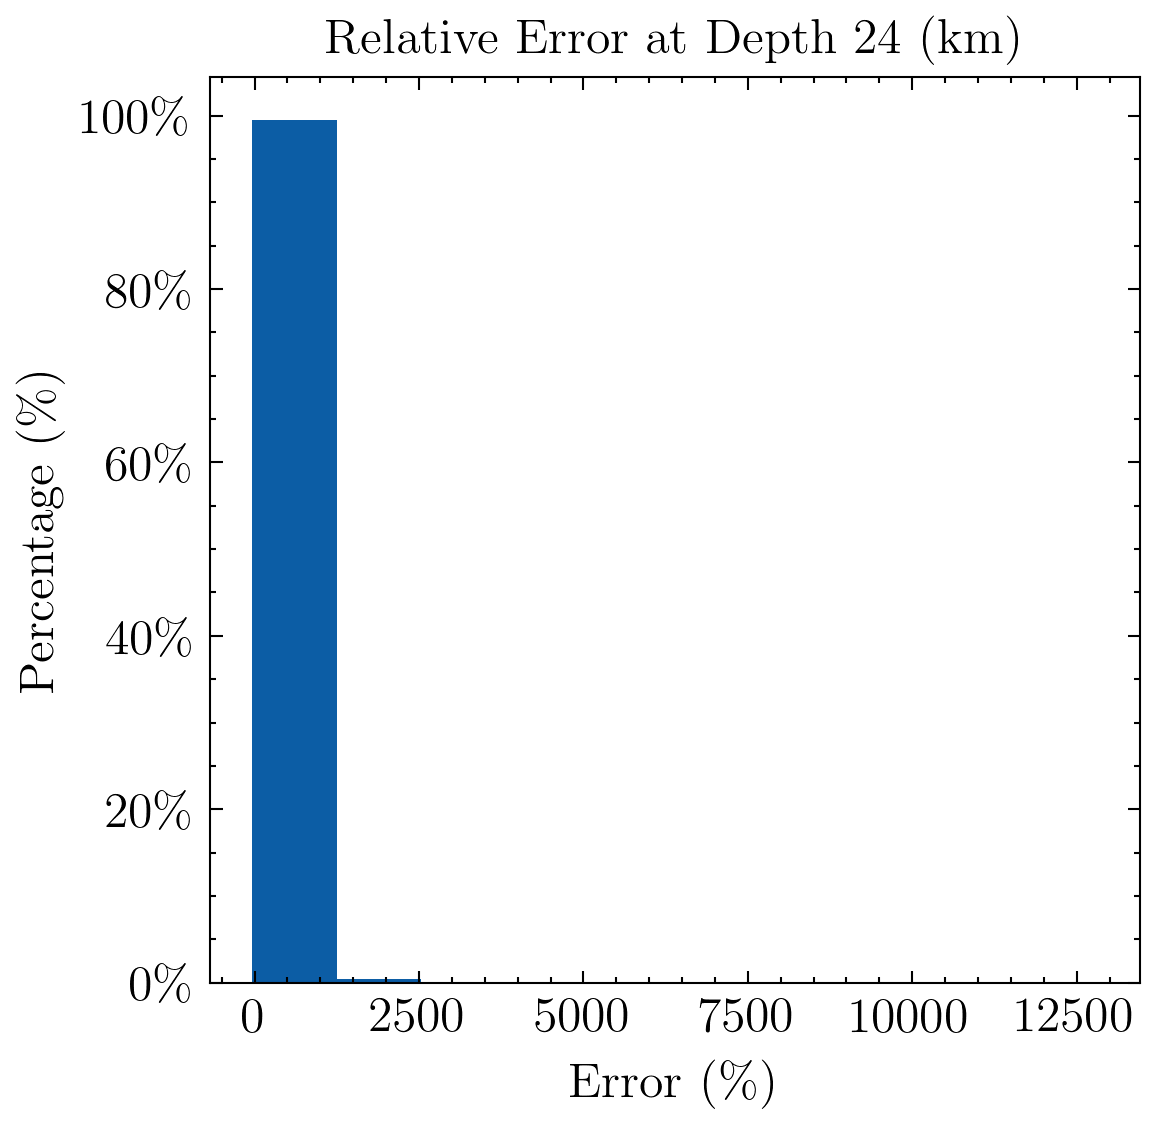

ValueError: Image size of 284045x1125 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x1200 with 1 Axes>

In [8]:
# prediction
for i in range(len(lon_sou)):

    if i%200==0:

        lat_i, alt_i, lon_i = np.meshgrid(latitude, -1e3*depth_plot, longitude)
        x_i, y_i, z_i = pm.geodetic2ecef(lat_i, lon_i, alt_i)
        _, dep_i, _ = np.meshgrid(latitude, depth_plot, longitude)

        # coordinates setup
        sx, sy, sz = pm.geodetic2ecef(lat_sou[i], lon_sou[i], -1e3*dep_sou)

        # rescale
        x,y,z = x_i/(ear_rad*1e3), y_i/(ear_rad*1e3), z_i/(ear_rad*1e3)
        sx, sy, sz = sx/(ear_rad*1e3), sy/(ear_rad*1e3), sz/(ear_rad*1e3)

        X,Y,Z = x,y,z

        print(X.size, lat_dim*dep_dim*lon_dim)

        # define receiver coordinates
        xR, yR, zR = X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)

        # define source coordinates
        xS, yS, zS = sx*np.ones_like(X.reshape(-1,1)), sy*np.ones_like(X.reshape(-1,1)), sz*np.ones_like(X.reshape(-1,1))

        # define input to the neural network
        Xo = np.hstack((xS, yS, zS, xR, yR, zR))


        Xq = torch.utils.data.DataLoader(
            torch.from_numpy(Xo).to(torch.float).to(torch.device('cuda')),
            batch_size=int(Xo.shape[0]//10)
        )

        t0 = time.time()
        T_pred = model.traveltimes(Xq, projection=False, normalization=True).cpu().reshape(-1, lat_dim, lon_dim)
        print('Predicted in ' + str(time.time()-t0))
        V_pred = model.velocity(Xq, projection=False, normalization=True).cpu().reshape(-1, lat_dim, lon_dim)

        V_pred, T_pred = V_pred*bac_vel, T_pred/bac_vel

        print(V_pred.shape)

        # construct xarray data
        pred = xr.Dataset({
            'V_pred': xr.DataArray(
                data=V_pred,
                dims=["depth", "latitude", "longitude"],
                coords=dict(
                    depth = (["depth"], np.array([depth_plot])),
                    longitude=(["longitude"], longitude),
                    latitude=(["latitude"], latitude),
                ),
                attrs=dict(
                    long_name='P-wave Velocity (Recovered)',
                    description="Recovered Vp.",
                    display_name='Vp (km.s^-1)',
                    units="km.s-1",
                )
        ),
        'V_res': xr.DataArray(
            data=(V_pred-data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].values),
            dims=["depth", "latitude", "longitude"],
            coords=dict(
                depth = (["depth"], np.array([depth_plot])),
                longitude=(["longitude"], longitude),
                latitude=(["latitude"], latitude),
            ),
            attrs=dict(
                long_name='P-wave Velocity Residual',
                description="Error Vp.",
                display_name='Vp (km.s^-1)',
                units="km.s-1",
            )
        ),
        'V_rel': xr.DataArray(
            data=100*(V_pred-data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].values)/data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].values,
            dims=["depth", "latitude", "longitude"],
            coords=dict(
                depth = (["depth"], np.array([depth_plot])),
                longitude=(["longitude"], longitude),
                latitude=(["latitude"], latitude),
            ),
            attrs=dict(
                long_name='P-wave Velocity Residual',
                description="Relative Error Vp.",
                display_name='Vp/Vp (\%)',
                units="unitless",
            )
        ),
        'T_pred': xr.DataArray(
            data=T_pred*ear_rad,
            dims=["depth", "latitude", "longitude"],
            coords=dict(
                depth = (["depth"], np.array([depth_plot])),
                longitude=(["longitude"], longitude),
                latitude=(["latitude"], latitude),
            ),
            attrs=dict(
                long_name='First-Arrival Travel Time (Modelled)',
                description="Recovered T.",
                display_name='T (s)',
                units="s",
                )
            )
        })

        fig = plt.figure(figsize=(4,4), dpi=300)
        ax = plt.axes(projection=ccrs.Robinson(180))

        # print(pred.T_pred.values.min(), dep_sou)

        ax.coastlines()
        ax.gridlines()
        pred.T_pred.plot(
            ax=ax, 
            transform=ccrs.PlateCarree(), 
            cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
            cmap='jet',
            vmin=pred.T_pred.values.min(),
            vmax=pred.T_pred.values.max()
        )
        plt.plot(lon_sou[i], lat_sou[i],color='black', markersize=10, marker='*',transform=ccrs.PlateCarree(), mec='white')
        plt.savefig(figures_path + 'T_pred_map_'+str(depth_plot)+'_lonlat_'+str(lon_sou[i])+str(lat_sou[i])+'.png', bbox_inches="tight")
        # plt.show()

        fig = plt.figure(figsize=(4,4), dpi=300)
        ax = plt.axes(projection=ccrs.Robinson(180))

        ax.coastlines()
        ax.gridlines()
        pred.V_pred.plot(
            ax=ax, 
            transform=ccrs.PlateCarree(), 
            cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
            cmap='jet',
            vmin=6.25, #np.min(pred.V_pred),
            vmax=data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].values.max()
        )
        plt.plot(lon_sou[i], lat_sou[i],color='black', markersize=10, marker='*',transform=ccrs.PlateCarree(), mec='white')
        plt.savefig(figures_path + 'V_pred_map_'+str(depth_plot)+'_lonlat_'+str(lon_sou[i])+str(lat_sou[i])+'.png', bbox_inches="tight")
        # plt.show()

        fig = plt.figure(figsize=(4,4), dpi=300)
        ax = plt.axes(projection=ccrs.Robinson(180))

        ax.coastlines()
        ax.gridlines()
        pred.V_rel.plot(
            ax=ax, 
            transform=ccrs.PlateCarree(), 
            cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
            cmap='jet'
        )
        plt.plot(lon_sou[i], lat_sou[i],color='black', markersize=10, marker='*',transform=ccrs.PlateCarree(), mec='white')
        plt.savefig(figures_path + 'V_rel_map_'+str(depth_plot)+'_lonlat_'+str(lon_sou[i])+str(lat_sou[i])+'.png', bbox_inches="tight")
        # plt.show()

        fig = plt.figure(figsize=(4,4), dpi=300)
        D = pred.V_rel.values.reshape(-1,)
        plt.hist(D, weights=np.ones(len(D)) / len(D))
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.title('Relative Error at Depth '+str(depth_plot)+' (km)')
        plt.ylabel('Percentage (\%)')
        plt.xlabel('Error (\%)')
        plt.savefig(figures_path + 'V_hist_rel_'+str(depth_plot)+'_lonlat_'+str(lon_sou[i])+str(lat_sou[i])+'.png', bbox_inches="tight")

        fig = plt.figure(figsize=(4,4), dpi=300)
        P = pred.V_pred.values.reshape(-1,)
        D = data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].values.reshape(-1,)
        n_P, bins_P, patches_P = plt.hist(
            P, 
            weights=np.ones(len(P)) / len(P), 
            bins=50, 
            histtype='step', 
            range=(D.min(), D.max()), 
            label='Recovered'
        )
        n_D, bins_D, patches_D = plt.hist(
            D, 
            weights=np.ones(len(P)) / len(P), 
            bins=50, 
            histtype='step', 
            range=(D.min(), D.max()), 
            label='Input'
        )
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        # plt.title('Velocity Histogram')
        plt.title('Velocity Histogram at Depth '+str(depth_plot)+' (km)')
        plt.ylabel('Percentage (\%)')
        plt.xlabel(r'Vp (km.s$^{-1}$)')
        plt.legend()
        plt.ylim(0,0.15)
        plt.text(
            np.max([D,P])-0.3*(np.max([D,P])-np.min([D,P])),
            0.12, 
            "CS="+str(round(1 - spatial.distance.cosine(n_D, n_P),3))
        )
        plt.savefig(figures_path + 'V_comp_hist_'+str(depth_plot)+'_lonlat_'+str(lon_sou[i])+str(lat_sou[i])+'.png', bbox_inches="tight")

        V_pred_mean = V_pred_mean + V_pred
        N = N + 1

V_pred_mean /= N

pred_mean = xr.Dataset({
        'V_pred_mean': xr.DataArray(
            data=V_pred_mean,
            dims=["depth", "latitude", "longitude"],
            coords=dict(
                depth = (["depth"], np.array([depth_plot])),
                longitude=(["longitude"], longitude),
                latitude=(["latitude"], latitude),
            ),
            attrs=dict(
                long_name='Mean P-wave Velocity (Recovered)',
                description="Recovered Vp.",
                display_name='Vp (km.s^-1)',
                units="km.s-1",
            )
        ),
        'V_res_mean': xr.DataArray(
            data=(V_pred_mean-data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].values),
            dims=["depth", "latitude", "longitude"],
            coords=dict(
                depth = (["depth"], np.array([depth_plot])),
                longitude=(["longitude"], longitude),
                latitude=(["latitude"], latitude),
            ),
            attrs=dict(
                long_name='Mean P-wave Velocity Residual',
                description="Error Vp.",
                display_name='Vp (km.s^-1)',
                units="km.s-1",
            )
        ),
        'V_rel_mean': xr.DataArray(
            data=100*(V_pred_mean-data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].values)/data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].values,
            dims=["depth", "latitude", "longitude"],
            coords=dict(
                depth = (["depth"], np.array([depth_plot])),
                longitude=(["longitude"], longitude),
                latitude=(["latitude"], latitude),
            ),
            attrs=dict(
                long_name='Mean P-wave Velocity Residual',
                description="Relative Error Vp.",
                display_name='Vp/Vp (\%)',
                units="unitless",
            )
        )
})

fig = plt.figure(figsize=(4,4), dpi=300)
ax = plt.axes(projection=ccrs.Robinson(180))
ax.coastlines()
ax.gridlines()
data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
    cmap='jet',
    vmin=6.25, #np.min(pred_mean.V_pred_mean),
    vmax=data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].values.max()
)

plt.plot(lon_sou[i], lat_sou[i],color='black', markersize=10, marker='*',transform=ccrs.PlateCarree(), mec='white')
plt.savefig(figures_path + 'V_ini_map_'+str(depth_plot)+'_lonlat_'+str(lon_sou[i])+str(lat_sou[i])+'.png', bbox_inches="tight")
# plt.show()

fig = plt.figure(figsize=(4,4), dpi=300)
ax = plt.axes(projection=ccrs.Robinson(180))

ax.coastlines()
ax.gridlines()
pred_mean.V_pred_mean.plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
    cmap='jet',
    vmin=6.25, #np.min(pred_mean.V_pred_mean),
    vmax=data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].values.max()
)
plt.plot(lon_sou[i], lat_sou[i],color='black', markersize=10, marker='*',transform=ccrs.PlateCarree(), mec='white')
plt.savefig(figures_path + 'V_pred_map_'+str(depth_plot)+'_mean.png', bbox_inches="tight")
# plt.show()

fig = plt.figure(figsize=(4,4), dpi=300)
ax = plt.axes(projection=ccrs.Robinson(180))

ax.coastlines()
ax.gridlines()
pred_mean.V_rel_mean.plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
    cmap='jet'
)
plt.plot(lon_sou[i], lat_sou[i],color='black', markersize=10, marker='*',transform=ccrs.PlateCarree(), mec='white')
plt.savefig(figures_path + 'V_rel_map_'+str(depth_plot)+'_mean.png', bbox_inches="tight")
# plt.show()

fig = plt.figure(figsize=(4,4), dpi=300)
D = pred_mean.V_rel_mean.values.reshape(-1,)
plt.hist(D, weights=np.ones(len(D)) / len(D))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Relative Error at Depth '+str(depth_plot)+' (km)')
plt.ylabel('Percentage (\%)')
plt.xlabel('Error (\%)')
plt.savefig(figures_path + 'V_hist_rel_'+str(depth_plot)+'_mean.png', bbox_inches="tight")

fig = plt.figure(figsize=(4,4), dpi=300)
P = pred_mean.V_pred_mean.values.reshape(-1,)
D = data.vpv[data.depth.values==depth_plot, lat_ini::lat_inc, lon_ini::lon_inc].values.reshape(-1,)
n_P, bins_P, patches_P = plt.hist(
    P, 
    weights=np.ones(len(P)) / len(P), 
    bins=50, 
    histtype='step', 
    range=(D.min(), D.max()), 
    label='Recovered'
)
n_D, bins_D, patches_D = plt.hist(
    D, 
    weights=np.ones(len(P)) / len(P), 
    bins=50, 
    histtype='step', 
    range=(D.min(), D.max()), 
    label='Input'
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.title('Velocity Histogram')
plt.title('Velocity Histogram at Depth '+str(depth_plot)+' (km)')
plt.ylabel('Percentage (\%)')
plt.xlabel(r'Vp (km.s$^{-1}$)')
plt.legend()
plt.ylim(0,0.15)
plt.text(
    np.max([D,P])-0.3*(np.max([D,P])-np.min([D,P])),
    0.12, 
    "CS="+str(round(1 - spatial.distance.cosine(n_D, n_P),3))
)
plt.savefig(figures_path + 'V_comp_hist_'+str(depth_plot)+'_mean.png', bbox_inches="tight")

In [10]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = plt.axes(projection=ccrs.Robinson(180))

# print(pred.T_pred.values.min(), dep_sou)

ax.coastlines()
ax.gridlines()
data.vpv.plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
    cmap='jet',
    vmin=6.25, #np.min(pred_mean.V_pred_mean),
    vmax=8
)

AttributeError: 'Rectangle' object has no property 'cbar_kwargs'

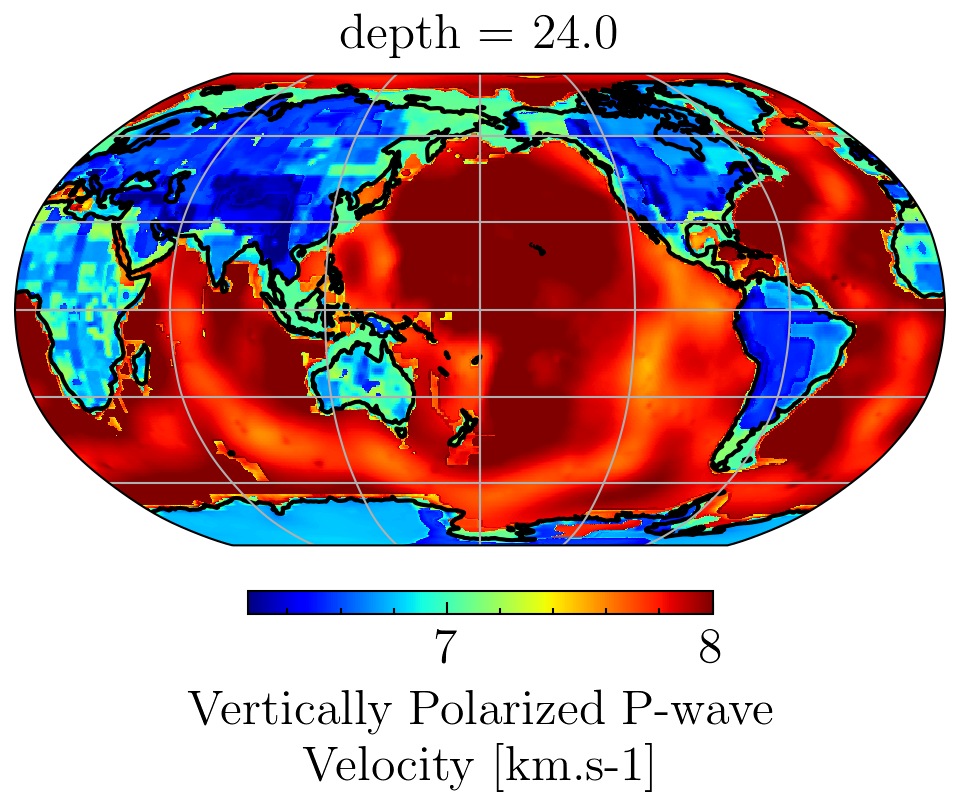

In [14]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = plt.axes(projection=ccrs.Robinson(180))
ax.coastlines()
ax.gridlines()
data.vpv[data.depth.values==depth_plot].plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cbar_kwargs={'shrink': 0.5, 'extend':'neither', 'orientation':'horizontal','pad':0.05}, 
    cmap='jet',
    vmin=6.25, #np.min(pred_mean.V_pred_mean),
    vmax=8
)